# Figure 1:  SMYLE & DPLE Global Surface Air Temperature ACC Maps

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [37]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a monthly mean CAM field with centered time coordinate
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [7]:
%%time
# SMYLE-NOV TREFHT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TREFHT'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunk = {'M':20,'L':8}
chunk = {}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 36.3 s, sys: 19 s, total: 55.4 s
Wall time: 1min 4s


5.202261672

In [9]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).load()
#smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
#daskresult = wait(smyle11_seas)

CPU times: user 40.7 s, sys: 5.43 s, total: 46.1 s
Wall time: 48.9 s


In [10]:
smyle11_seas

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, L: 8, Y: 49, M: 20)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 3 6 9 12 15 18 21 24
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    TREFHT   (Y, L, M, lat, lon) float64 257.3 257.3 257.3 257.3 ... nan nan nan
    time     (Y, L) object 1971-01-15 00:00:00 ... 2020-10-15 00:00:00
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSMYLE.f09_g17.1970-11.001
    logname:           sglanvil
    host:              cheyenne4
    initial_file:      b.e21.SMYLE_IC.f09_g17.1970-11.01.cam.i.1970-11-01-000...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [11]:
%%time
# SMYLE-FEB TREFHT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TREFHT'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunk = {'M':20,'L':8}
chunk = {}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 35.7 s, sys: 18.6 s, total: 54.3 s
Wall time: 57.7 s


5.202261672

In [12]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).load()
#smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
#daskresult = wait(smyle02_seas)

CPU times: user 44.2 s, sys: 5.04 s, total: 49.3 s
Wall time: 51.1 s


In [13]:
%%time
# SMYLE-MAY TREFHT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TREFHT'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 35.3 s, sys: 18.4 s, total: 53.7 s
Wall time: 58.3 s


5.202261672

In [19]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).load()
#smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
#daskresult = wait(smyle05_seas)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2b3484f4ac40>>
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/utils_perf.py", line 192, in _gc_callback
    self._fractional_timer.start_timing()
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/utils_perf.py", line 115, in start_timing
    assert self._cur_start is None
AssertionError: 


CPU times: user 46.3 s, sys: 4.87 s, total: 51.2 s
Wall time: 53.9 s


In [20]:
%%time
# SMYLE-AUG TREFHT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TREFHT'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 35.1 s, sys: 18.6 s, total: 53.7 s
Wall time: 57.2 s


5.202261672

In [21]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).load()
#smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
#daskresult = wait(smyle08_seas)

CPU times: user 47.6 s, sys: 5 s, total: 52.6 s
Wall time: 55.2 s


In [22]:
%%time
# DPLE-NOV TREFHT data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'TREFHT'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11.nbytes/1e9 #GB

CPU times: user 14.2 s, sys: 2.69 s, total: 16.9 s
Wall time: 21.7 s


10.192172672

In [23]:
%%time
dple11_seas = cal.mon_to_seas_dask(dple11).persist()
#dple11_seas = cal.mon_to_seas_dask(dple11).persist()
#daskresult = wait(dple11_seas)

CPU times: user 30.7 s, sys: 99.4 ms, total: 30.8 s
Wall time: 31.7 s


### DataArrays are manageable size now (and in memory), so Dask cluster could be released 

In [28]:
cluster.close()
client.close()

In [20]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas.to_netcdf(outdir+'DPLE11_SAT_seas.nc')
smyle11_seas.to_netcdf(outdir+'SMYLE11_SAT_seas.nc')
smyle02_seas.to_netcdf(outdir+'SMYLE02_SAT_seas.nc')
smyle05_seas.to_netcdf(outdir+'SMYLE05_SAT_seas.nc')
smyle08_seas.to_netcdf(outdir+'SMYLE08_SAT_seas.nc')

CPU times: user 235 ms, sys: 3.99 s, total: 4.23 s
Wall time: 6.03 s


In [5]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_SAT_seas.nc')
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_SAT_seas.nc')
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_SAT_seas.nc')
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_SAT_seas.nc')
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_SAT_seas.nc')

### Regrid Hindcast data

In [6]:
## Define 5x5 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,95,5),'lon':np.arange(0,360,5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [7]:
dple11_seas = regrid.add_grid_bounds(dple11_seas)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [8]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(dple11_seas, destgrid, 'conservative', periodic=True)

In [9]:
%%time
dple11_da = regrid_cam1deg(dple11_seas.TREFHT)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 2.83 s, sys: 2.53 s, total: 5.36 s
Wall time: 7.35 s


In [10]:
%%time
smyle11_da = regrid_cam1deg(smyle11_seas.TREFHT)
smyle02_da = regrid_cam1deg(smyle02_seas.TREFHT)
smyle05_da = regrid_cam1deg(smyle05_seas.TREFHT)
smyle08_da = regrid_cam1deg(smyle08_seas.TREFHT)

CPU times: user 5.86 s, sys: 5.14 s, total: 11 s
Wall time: 16.4 s


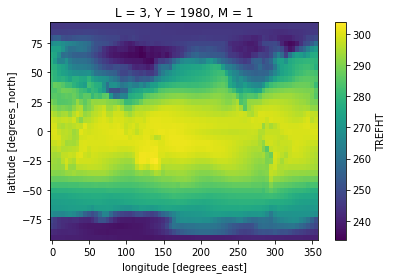

In [11]:
dple11_da.isel(Y=10,L=0,M=0).plot();

### Get surface temperature OBS

In [12]:
# CRU TS4.05  (0.5deg SAT over land)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_cru = xr.open_dataset(obs_dir+'mon/SAT/cru_ts4.05.1901.2020.tmp.dat.nc',decode_times=False)
cru_montime_vals = [cftime.DatetimeNoLeap(1901+year, 1+month, 15) for year in range(120) for month in range(12)]
ds_cru['time'] = cru_montime_vals
ds_cru = ds_cru.sel(time=slice("1960","2020"))

In [13]:
# ERSSTv5  (2deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_ersstv5 = xr.open_dataset(obs_dir+'mon/SST/ersst.v5.188001-202012.nc')
nt = np.size(ds_ersstv5.time)
ersstv5_montime_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_ersstv5['time'] = ersstv5_montime_vals
ds_ersstv5 = ds_ersstv5.sel(time=slice("1960","2020"))

In [14]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

### Compute OBS seasonal averages

In [15]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [16]:
cru_ts_seas = obs_convert_mon_to_seas(ds_cru.tmp,'TS')

In [17]:
hadisst_ts_seas = obs_convert_mon_to_seas(ds_hadisst.sst,'TS')

In [18]:
cru_ts_seas = regrid.add_grid_bounds(cru_ts_seas)

In [19]:
hadisst_ts_seas = hadisst_ts_seas.rename({'latitude':'lat','longitude':'lon'})
hadisst_ts_seas['lat'] = hadisst_ts_seas['lat'].assign_attrs({'long_name':'latitude'})
hadisst_ts_seas['lon'] = hadisst_ts_seas['lon'].assign_attrs({'long_name':'longitude'})
hadisst_ts_seas = regrid.add_grid_bounds(hadisst_ts_seas)

### Regrid & Merge SAT OBS

In [20]:
%%time
regrid_cru = xe.Regridder(cru_ts_seas, destgrid, 'conservative', periodic=True)
cru_ts_seas_rg = regrid_cru(cru_ts_seas.TS,skipna=True, na_thres=0.6)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 7.41 s, sys: 430 ms, total: 7.84 s
Wall time: 8.14 s


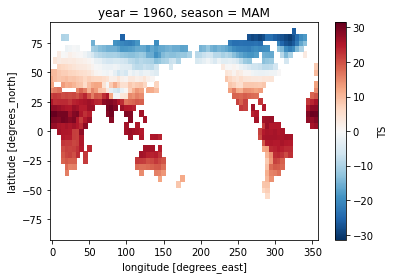

In [21]:
cru_ts_seas_rg.isel(year=0,season=1).plot()

In [22]:
hadisst_ts_seas['mask'] = xr.where(~np.isnan(hadisst_ts_seas["TS"].isel(year=0,season=1)), 1, 0)

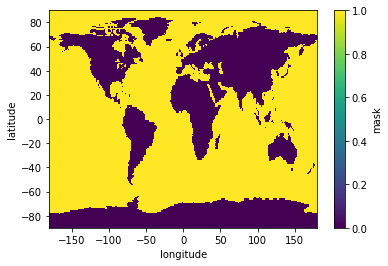

In [23]:
hadisst_ts_seas.mask.plot()

In [24]:
%%time
regrid_had = xe.Regridder(hadisst_ts_seas, destgrid, 'conservative', periodic=True)
had_ts_seas_rg = regrid_had(hadisst_ts_seas.TS,skipna=True, na_thres=0.9)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 1.71 s, sys: 89.2 ms, total: 1.8 s
Wall time: 1.87 s


In [25]:
def merge_obs(da1,da2):
    return da1.fillna(da2)

In [26]:
cruhad = merge_obs(cru_ts_seas_rg,had_ts_seas_rg)

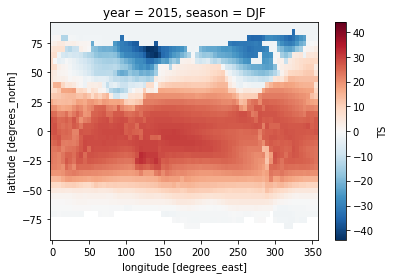

In [27]:
cruhad.isel(season=0).sel(year=2015).plot();

In [28]:
## convert OBS to anomalies from 1972-2017
cruhad = cruhad - cruhad.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [29]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_da,smyle11_seas.time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11_da,dple11_seas.time.load(),1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_da,smyle02_seas.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_da,smyle05_seas.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_da,smyle08_seas.time,1972,2017)

CPU times: user 982 ms, sys: 613 ms, total: 1.59 s
Wall time: 1.64 s


In [31]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,cruhad,100,20)

CPU times: user 1min 14s, sys: 1.68 s, total: 1min 16s
Wall time: 1min 39s


In [32]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,cruhad)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,cruhad)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,cruhad)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,cruhad)

CPU times: user 1.78 s, sys: 4.16 ms, total: 1.78 s
Wall time: 1.83 s


CPU times: user 5.44 s, sys: 58.8 ms, total: 5.5 s
Wall time: 6.35 s


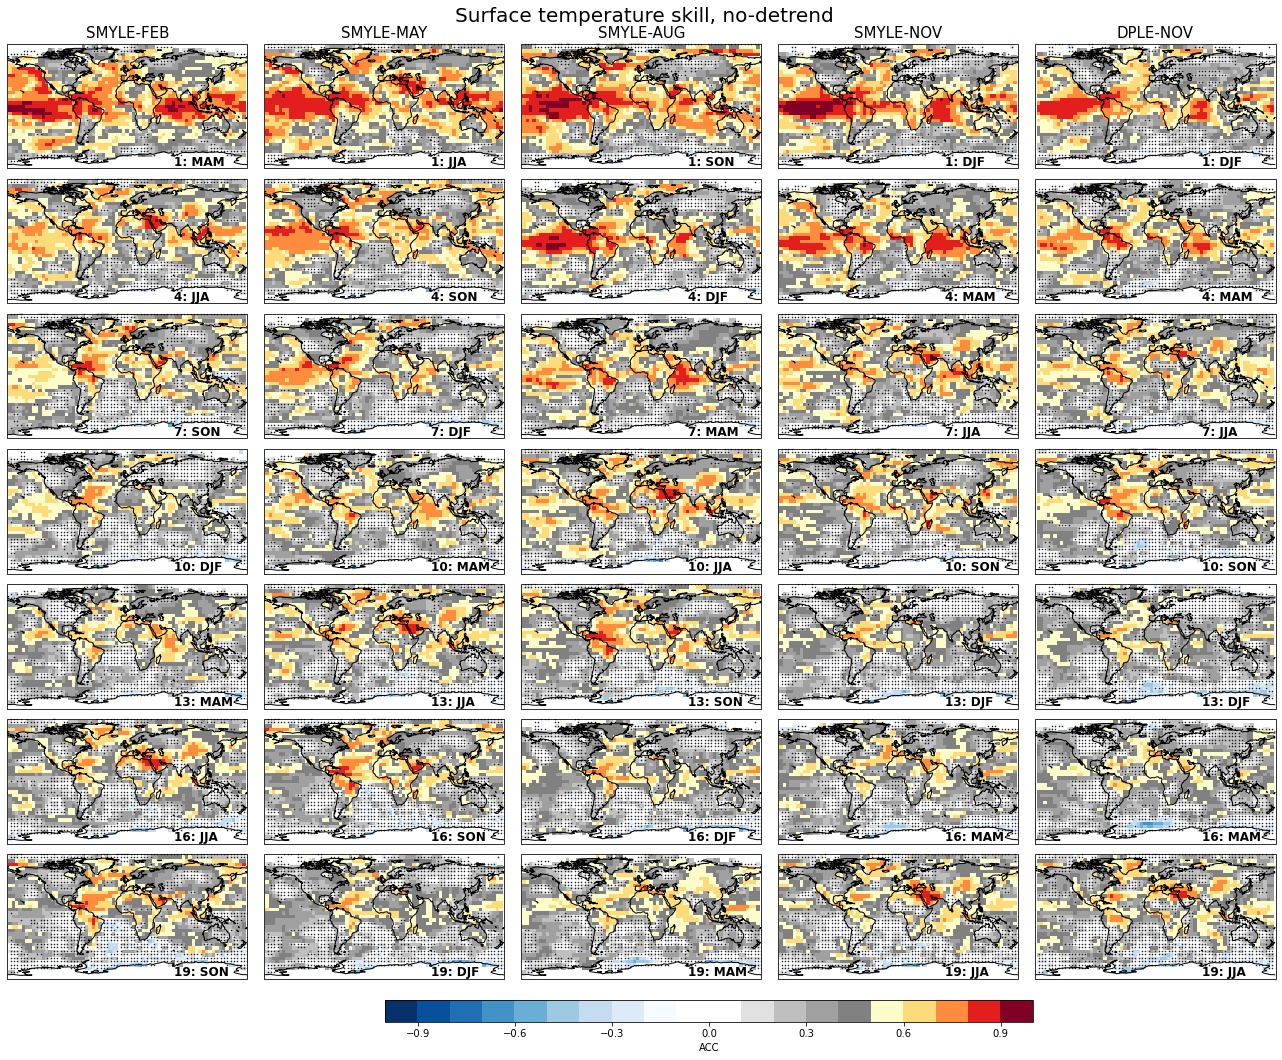

In [33]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_skill.pval.isel(L=i), smyle05_skill.lon, smyle05_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_skill.pval.isel(L=i), smyle08_skill.lon, smyle08_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_skill.pval.isel(L=i), smyle11_skill.lon, smyle11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_skill.pval.isel(L=i), dple11_skill.lon, dple11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig01_SAT_ACC_nodetrend.png')

### Test Significance Hatching using correlation p-values

CPU times: user 106 ms, sys: 2.94 ms, total: 109 ms
Wall time: 109 ms


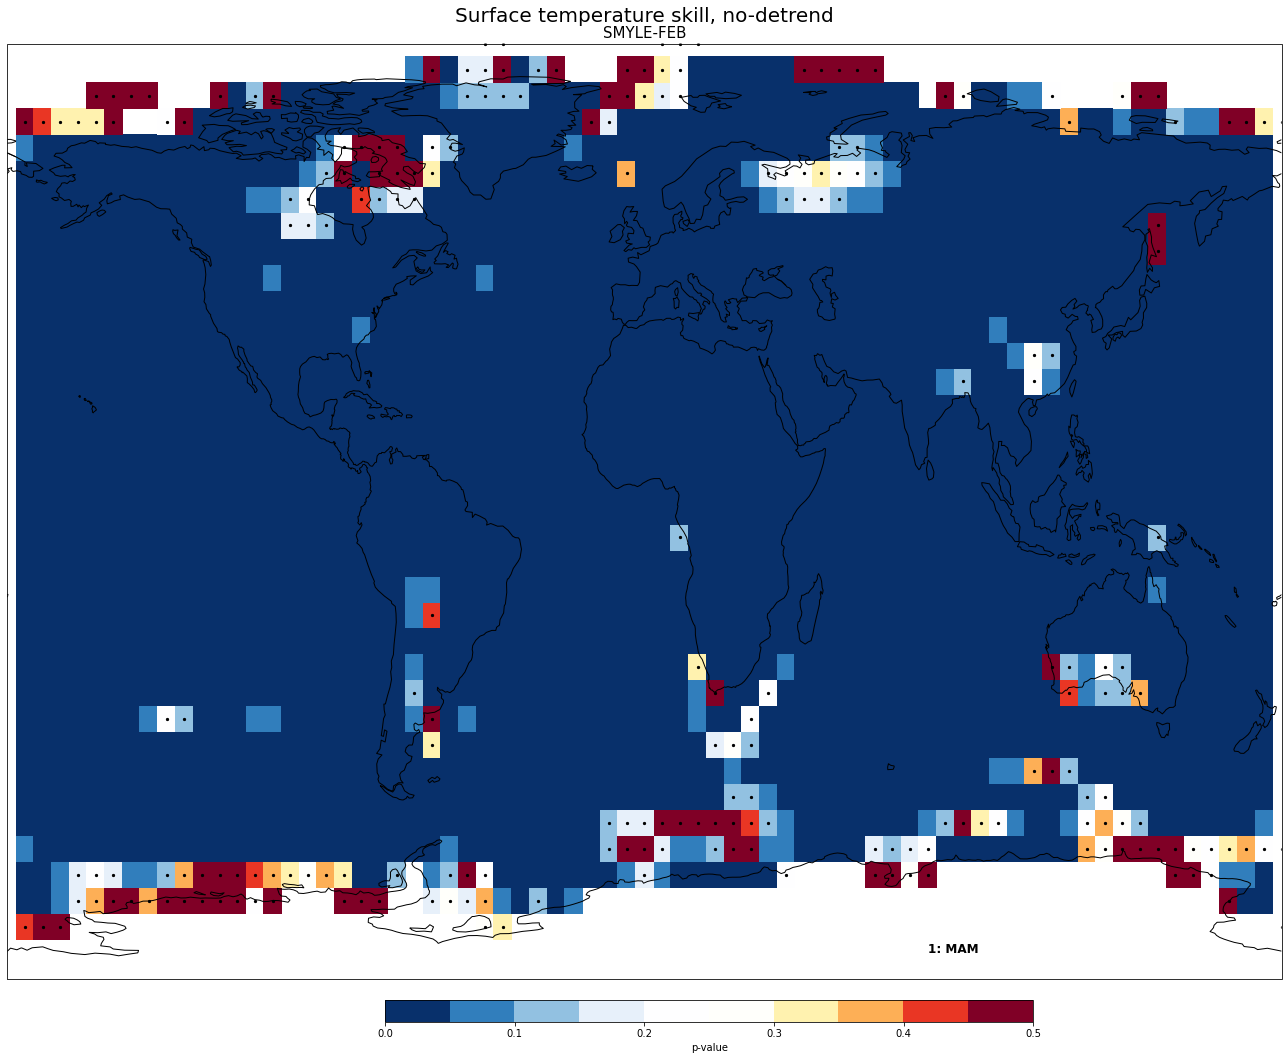

In [34]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=20,marker=".")
    ldstr = str(i+1) + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [30]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,cruhad,100,20,detrend=True)

CPU times: user 3min 15s, sys: 2.47 s, total: 3min 18s
Wall time: 3min 53s


In [31]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,cruhad,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,cruhad,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,cruhad,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,cruhad,detrend=True)

CPU times: user 9.59 s, sys: 66.5 ms, total: 9.66 s
Wall time: 9.94 s


CPU times: user 5.65 s, sys: 78.2 ms, total: 5.73 s
Wall time: 5.89 s


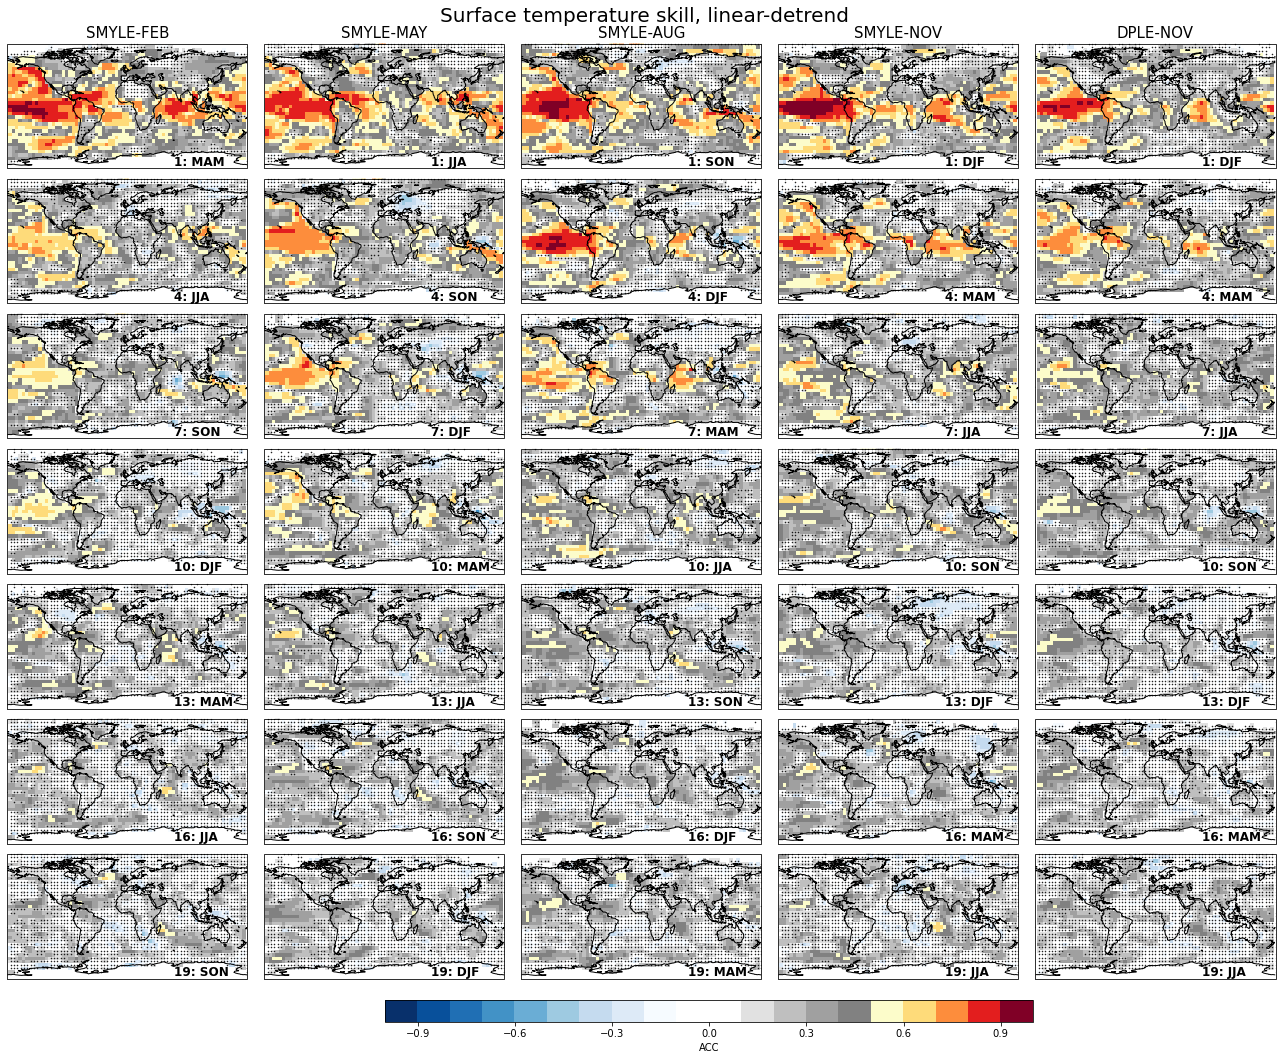

In [33]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_skill.pval.isel(L=i), smyle05_skill.lon, smyle05_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_skill.pval.isel(L=i), smyle08_skill.lon, smyle08_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_skill.pval.isel(L=i), smyle11_skill.lon, smyle11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_skill.pval.isel(L=i), dple11_skill.lon, dple11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig01_SAT_ACC_lineardetrend.png')

### Look at subsampled skill maps

In [34]:
hadisst_ts_seas.TS.sel(year=slice(1970,2018)).year

<xarray.DataArray 'year' (year: 49)>
array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])
Coordinates:
  * year     (year) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018

In [35]:
obs_dat = hadisst_ts_seas.TS.sel(year=slice(1970,2018))
obs_nino34 = obs_dat.sel(lat=slice(5,-5)).sel(lon=slice(-170,-120)).mean(("lon", "lat"))

In [36]:
obs_nino34 = obs_nino34 - obs_nino34.mean('year')
obs_nino34 = obs_nino34/obs_nino34.std('year')

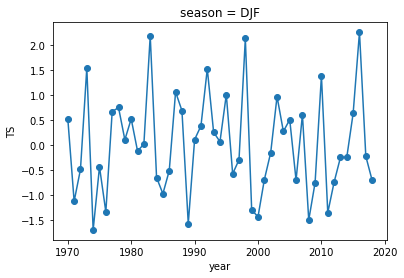

In [37]:
obs_nino34.sel(season='DJF').plot(marker='o');

In [38]:
bignino = obs_nino34.where(abs(obs_nino34)>1)

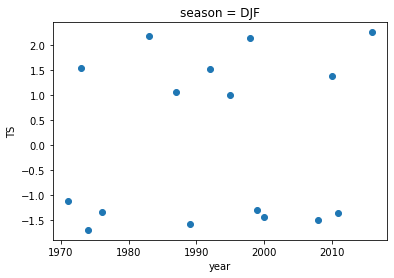

In [39]:
bignino.sel(season='DJF').plot(marker='o',linestyle="none");

In [40]:
bignino.sel(season='DJF').dropna(dim='year').year

<xarray.DataArray 'year' (year: 16)>
array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000,
       2008, 2010, 2011, 2016])
Coordinates:
  * year     (year) int64 1971 1973 1974 1976 1983 ... 2000 2008 2010 2011 2016
    season   <U3 'DJF'

In [41]:
keepyears = bignino.sel(season='DJF').dropna(dim='year').year.data

In [42]:
keepyears

array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999,
       2000, 2008, 2010, 2011, 2016])

In [43]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom.sel(Y=keep11),smyle11_seas.time.sel(Y=keep11),cruhad,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom.sel(Y=keep02),smyle02_seas.time.sel(Y=keep02),cruhad,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom.sel(Y=keep05),smyle05_seas.time.sel(Y=keep05),cruhad,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom.sel(Y=keep08),smyle08_seas.time.sel(Y=keep08),cruhad,detrend=True)

CPU times: user 7.5 s, sys: 137 ms, total: 7.64 s
Wall time: 8.5 s


In [44]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom.sel(Y=keep11),dple11_seas.time.sel(Y=keep11),cruhad,100,20,detrend=True)

CPU times: user 3min 17s, sys: 2.42 s, total: 3min 19s
Wall time: 3min 51s


CPU times: user 5.73 s, sys: 105 ms, total: 5.84 s
Wall time: 6.01 s


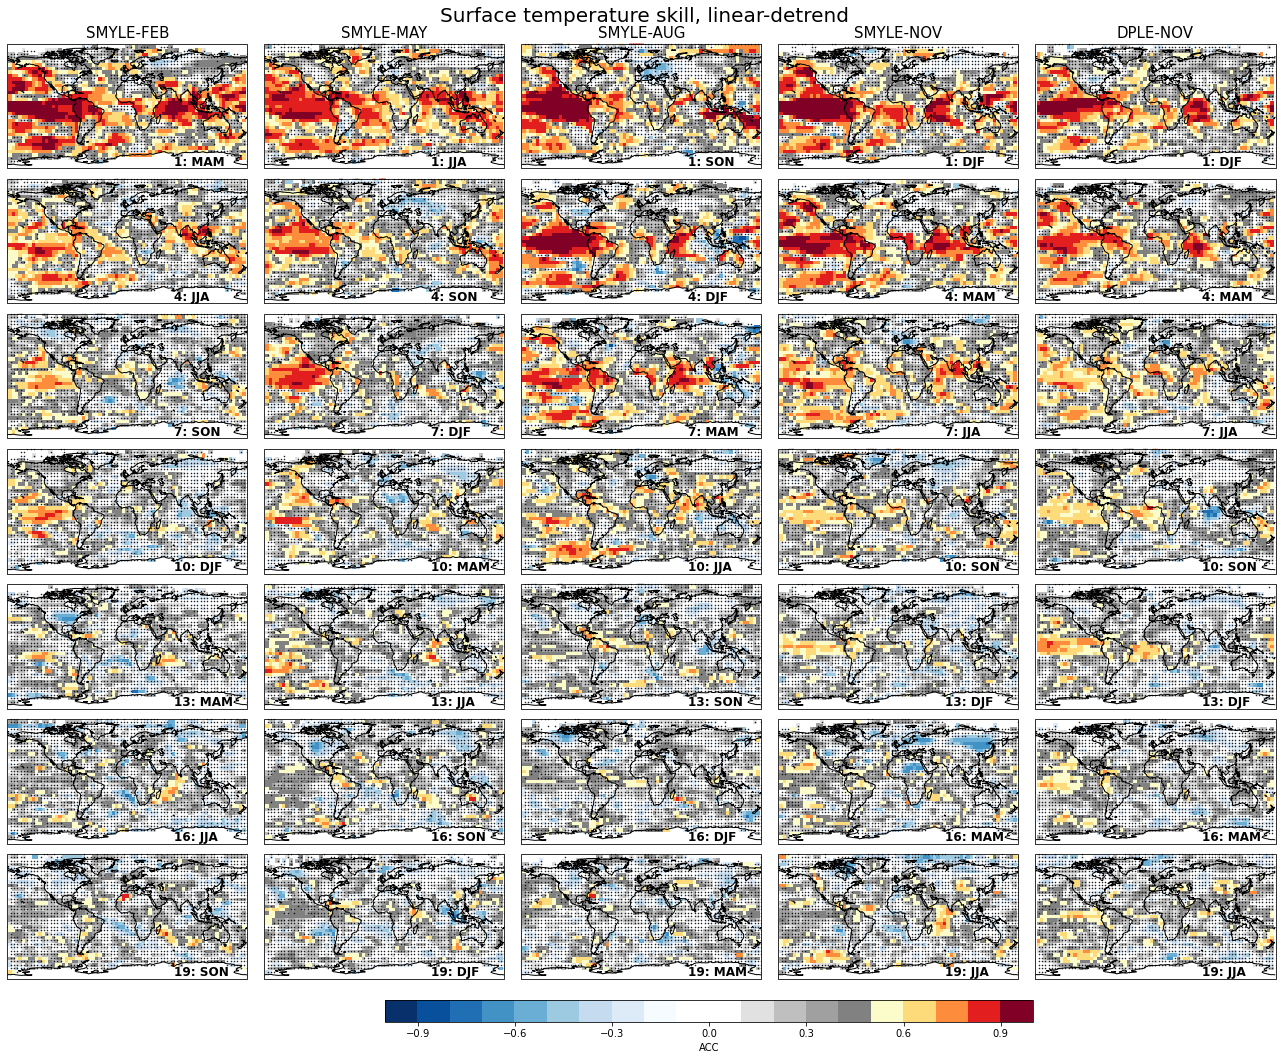

In [45]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_skill.pval.isel(L=i), smyle05_skill.lon, smyle05_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_skill.pval.isel(L=i), smyle08_skill.lon, smyle08_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_skill.pval.isel(L=i), smyle11_skill.lon, smyle11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_skill.pval.isel(L=i), dple11_skill.lon, dple11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig01_SAT_ACC_lineardetrend_subsamp.png')